# Data Adquisition

We have 2 sources of data to analyze in this project:
- [Drugs reviews dataset](https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018)
- [COVID 19 symptoms Dataset](https://www.kaggle.com/iamhungundji/covid19-symptoms-checker)
<br/>
Let's download the datasets into a Data folder, this datasets will be included in the gitignore, so  you need to download the datasets as the first step to run the project.<br/>
For this we are going to use opendatasets, which will allow us to download datasets from kaggle, when downloading the datasets, you'll need to provide an authentication token related to your kaggle account, you can see more information on:
* [Generate Kaggle authentication token](https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook)

In [1]:
# Install package if it's not already installed
!pip install opendatasets
import opendatasets as od
# Download dataset in Data folder
drugs_review_url = "https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018/download"
covid_url = "https://www.kaggle.com/iamhungundji/covid19-symptoms-checker"
od.download(drugs_review_url,data_dir='../Data')
od.download(covid_url,data_dir='../Data')

Skipping, found downloaded files in "../Data\kuc-hackathon-winter-2018" (use force=True to force download)
Skipping, found downloaded files in "../Data\covid19-symptoms-checker" (use force=True to force download)


# Lets have a look to our datasets!

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

## COVID Symptomps dataset

Let's import our dataset

In [3]:
covid_data = pd.read_csv("../Data/covid19-symptoms-checker/Raw-Data.csv")
covid_data.head(20)

,Country,Age,Gender,Symptoms,Experiencing_Symptoms,Severity,Contact
0,China,0-9,Male,"Fever,Tiredness,Dry-Cough,Difficulty-in-Breath...","Pains,Nasal-Congestion,Runny-Nose,Diarrhea",Mild,Yes
1,Italy,10-19,Female,"Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing","Pains,Nasal-Congestion,Runny-Nose",Moderate,No
2,Iran,20-24,Transgender,"Fever,Tiredness,Dry-Cough","Pains,Nasal-Congestion",Severe,Dont-Know
3,Republic of Korean,25-59,NaN,"Fever,Tiredness",Pains,None,NaN
4,France,60+,NaN,Fever,"Nasal-Congestion,Runny-Nose,Diarrhea",NaN,NaN
5,Spain,NaN,NaN,"Tiredness,Dry-Cough,Difficulty-in-Breathing,So...","Nasal-Congestion,Runny-Nose",NaN,NaN
6,Germany,NaN,NaN,"Tiredness,Dry-Cough,Difficulty-in-Breathing",Nasal-Congestion,NaN,NaN
7,UAE,NaN,NaN,"Tiredness,Dry-Cough","Runny-Nose,Diarrhea",NaN,NaN
8,Other-EUR,NaN,NaN,Tiredness,Runny-Nose,NaN,NaN
9,Other,NaN,NaN,"Dry-Cough,Difficulty-in-Breathing,Sore-Throat",Diarrhea,NaN,NaN


As we don't have enough data in our files, we are going to generate all the possible combinations using the data we received

In [4]:
#generating all not null values combination
import itertools
columns = [covid_data.Country.dropna().unique().tolist(),
          covid_data.Age.dropna().unique().tolist(),
          covid_data.Gender.dropna().unique().tolist(),
          covid_data.Symptoms.dropna().unique().tolist(),
          covid_data.Experiencing_Symptoms.dropna().unique().tolist(),
          covid_data.Severity.dropna().unique().tolist(),
          covid_data.Contact.dropna().unique().tolist()]

combined_data = pd.DataFrame(list(itertools.product(*columns)), columns=covid_data.columns)

In [5]:
combined_data.shape

(316800, 7)

In [6]:
combined_data.head()

,Country,Age,Gender,Symptoms,Experiencing_Symptoms,Severity,Contact
0,China,0-9,Male,"Fever,Tiredness,Dry-Cough,Difficulty-in-Breath...","Pains,Nasal-Congestion,Runny-Nose,Diarrhea",Mild,Yes
1,China,0-9,Male,"Fever,Tiredness,Dry-Cough,Difficulty-in-Breath...","Pains,Nasal-Congestion,Runny-Nose,Diarrhea",Mild,No
2,China,0-9,Male,"Fever,Tiredness,Dry-Cough,Difficulty-in-Breath...","Pains,Nasal-Congestion,Runny-Nose,Diarrhea",Mild,Dont-Know
3,China,0-9,Male,"Fever,Tiredness,Dry-Cough,Difficulty-in-Breath...","Pains,Nasal-Congestion,Runny-Nose,Diarrhea",Moderate,Yes
4,China,0-9,Male,"Fever,Tiredness,Dry-Cough,Difficulty-in-Breath...","Pains,Nasal-Congestion,Runny-Nose,Diarrhea",Moderate,No


Gender, Age and Contact columns are categorical features, which we are going to process using get dummies

In [7]:
combined_data = pd.get_dummies(combined_data,columns=['Age', 'Contact', 'Gender'])

Symptoms and experiecing symptoms are categorical columns but they're not that easy to process, let's find all the unique values

In [8]:
#We get all the unique values of symptoms
unique_symptoms = []
# Using covid data to save computing time

for index,row in covid_data.iterrows():
    unique_symptoms = unique_symptoms + str(row['Symptoms']).split(',') + str(row['Experiencing_Symptoms']).split(',')
unique_symptoms = set(unique_symptoms)
unique_symptoms.remove('nan')
unique_symptoms

{'Diarrhea',
 'Difficulty-in-Breathing',
 'Dry-Cough',
 'Fever',
 'Nasal-Congestion',
 'None_Experiencing',
 'None_Sympton',
 'Pains',
 'Runny-Nose',
 'Sore-Throat',
 'Tiredness'}

In [9]:
#we create this categorical columns filled with 0s
for symp in unique_symptoms:
    combined_data[symp] = 0
combined_data.head()

,Country,Symptoms,Experiencing_Symptoms,Severity,Age_0-9,Age_10-19,Age_20-24,Age_25-59,Age_60+,Contact_Dont-Know,...,Runny-Nose,Tiredness,None_Sympton,Pains,Sore-Throat,Fever,Difficulty-in-Breathing,Diarrhea,Dry-Cough,None_Experiencing
0,China,"Fever,Tiredness,Dry-Cough,Difficulty-in-Breath...","Pains,Nasal-Congestion,Runny-Nose,Diarrhea",Mild,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,China,"Fever,Tiredness,Dry-Cough,Difficulty-in-Breath...","Pains,Nasal-Congestion,Runny-Nose,Diarrhea",Mild,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,China,"Fever,Tiredness,Dry-Cough,Difficulty-in-Breath...","Pains,Nasal-Congestion,Runny-Nose,Diarrhea",Mild,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,China,"Fever,Tiredness,Dry-Cough,Difficulty-in-Breath...","Pains,Nasal-Congestion,Runny-Nose,Diarrhea",Moderate,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,China,"Fever,Tiredness,Dry-Cough,Difficulty-in-Breath...","Pains,Nasal-Congestion,Runny-Nose,Diarrhea",Moderate,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Now we merge symptoms and experiencing symptoms features
combined_data['all_symptoms'] = (combined_data['Symptoms'] + ',' + combined_data['Experiencing_Symptoms']).apply(lambda x: x.split(','))
combined_data.drop(axis=1, columns=['Symptoms','Experiencing_Symptoms'], inplace=True)
combined_data.head()

,Country,Severity,Age_0-9,Age_10-19,Age_20-24,Age_25-59,Age_60+,Contact_Dont-Know,Contact_No,Contact_Yes,...,Tiredness,None_Sympton,Pains,Sore-Throat,Fever,Difficulty-in-Breathing,Diarrhea,Dry-Cough,None_Experiencing,all_symptoms
0,China,Mild,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[Fever, Tiredness, Dry-Cough, Difficulty-in-Br..."
1,China,Mild,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[Fever, Tiredness, Dry-Cough, Difficulty-in-Br..."
2,China,Mild,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"[Fever, Tiredness, Dry-Cough, Difficulty-in-Br..."
3,China,Moderate,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[Fever, Tiredness, Dry-Cough, Difficulty-in-Br..."
4,China,Moderate,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[Fever, Tiredness, Dry-Cough, Difficulty-in-Br..."


In [11]:
# let's assign symptoms using the all_symptoms columns
def generate_symptoms(data):
    for s in data['all_symptoms']:
        data[s] = 1
    return data
combined_data = combined_data.apply(generate_symptoms, axis=1)
combined_data.head()

,Country,Severity,Age_0-9,Age_10-19,Age_20-24,Age_25-59,Age_60+,Contact_Dont-Know,Contact_No,Contact_Yes,...,Tiredness,None_Sympton,Pains,Sore-Throat,Fever,Difficulty-in-Breathing,Diarrhea,Dry-Cough,None_Experiencing,all_symptoms
0,China,Mild,1,0,0,0,0,0,0,1,...,1,0,1,1,1,1,1,1,0,"[Fever, Tiredness, Dry-Cough, Difficulty-in-Br..."
1,China,Mild,1,0,0,0,0,0,1,0,...,1,0,1,1,1,1,1,1,0,"[Fever, Tiredness, Dry-Cough, Difficulty-in-Br..."
2,China,Mild,1,0,0,0,0,1,0,0,...,1,0,1,1,1,1,1,1,0,"[Fever, Tiredness, Dry-Cough, Difficulty-in-Br..."
3,China,Moderate,1,0,0,0,0,0,0,1,...,1,0,1,1,1,1,1,1,0,"[Fever, Tiredness, Dry-Cough, Difficulty-in-Br..."
4,China,Moderate,1,0,0,0,0,0,1,0,...,1,0,1,1,1,1,1,1,0,"[Fever, Tiredness, Dry-Cough, Difficulty-in-Br..."


In [12]:
# let's drop the all_symptoms column
combined_data.drop(axis=1,columns=['all_symptoms'], inplace=True)
combined_data.head()

,Country,Severity,Age_0-9,Age_10-19,Age_20-24,Age_25-59,Age_60+,Contact_Dont-Know,Contact_No,Contact_Yes,...,Runny-Nose,Tiredness,None_Sympton,Pains,Sore-Throat,Fever,Difficulty-in-Breathing,Diarrhea,Dry-Cough,None_Experiencing
0,China,Mild,1,0,0,0,0,0,0,1,...,1,1,0,1,1,1,1,1,1,0
1,China,Mild,1,0,0,0,0,0,1,0,...,1,1,0,1,1,1,1,1,1,0
2,China,Mild,1,0,0,0,0,1,0,0,...,1,1,0,1,1,1,1,1,1,0
3,China,Moderate,1,0,0,0,0,0,0,1,...,1,1,0,1,1,1,1,1,1,0
4,China,Moderate,1,0,0,0,0,0,1,0,...,1,1,0,1,1,1,1,1,1,0


In [13]:
combined_data.Severity.unique()
severity_dict = {
    "None" : 0,
    "Mild" : 1,
    "Moderate" : 2,
    "Severe" : 3
}
combined_data.Severity = combined_data.Severity.apply(lambda x: severity_dict[x])
combined_data.head()

,Country,Severity,Age_0-9,Age_10-19,Age_20-24,Age_25-59,Age_60+,Contact_Dont-Know,Contact_No,Contact_Yes,...,Runny-Nose,Tiredness,None_Sympton,Pains,Sore-Throat,Fever,Difficulty-in-Breathing,Diarrhea,Dry-Cough,None_Experiencing
0,China,1,1,0,0,0,0,0,0,1,...,1,1,0,1,1,1,1,1,1,0
1,China,1,1,0,0,0,0,0,1,0,...,1,1,0,1,1,1,1,1,1,0
2,China,1,1,0,0,0,0,1,0,0,...,1,1,0,1,1,1,1,1,1,0
3,China,2,1,0,0,0,0,0,0,1,...,1,1,0,1,1,1,1,1,1,0
4,China,2,1,0,0,0,0,0,1,0,...,1,1,0,1,1,1,1,1,1,0


Let's make some plots of the data

Text(0.5, 1.0, 'Cases per country')

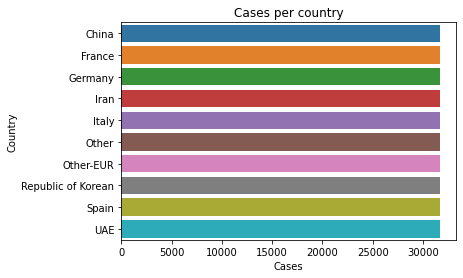

In [14]:
#number of cases per country
country_data = pd.DataFrame(combined_data.groupby(by=['Country']).count()['Severity']).reset_index().rename(columns={'Severity':'Cases'})
ax = sns.barplot(x="Cases", y="Country", data=country_data)
plt.title('Cases per country')

By watching this plot, we've realized that thi dataset won't work, as the data is perfectly distributed, therefore, the ML algorithm won't be able to learn to properly categorize the data.

In [15]:
del(covid_data)
del(country_data)
del(combined_data)
del(unique_symptoms)

## Drugs review dataset
Data is already split on training and testing data, let's import both datasets

In [72]:
drugs_train = pd.read_csv("../Data/kuc-hackathon-winter-2018/drugsComTrain_raw.csv")
drugs_test = pd.read_csv("../Data/kuc-hackathon-winter-2018/drugsComTest_raw.csv")
drugs_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


Our goal is to be able to predict the condition using the rest of the data, we have some features which are useless for this task, such as uniqueID, date and usefulCoun, we are going to drop this features so we can focus on the ones we need.

In [73]:
drugs_train.drop(['uniqueID', 'date','usefulCount','rating'], axis=1, inplace=True)
drugs_test.drop(['uniqueID', 'date','usefulCount','rating'], axis=1, inplace=True)

Let's see how many elements we have in our datasets

In [74]:
drugs_train.shape

(161297, 3)

In [75]:
drugs_test.shape

(53766, 3)

Now let's check if any of these features have missing values

In [76]:
display("NULL Values", drugs_train.isnull().sum())

'NULL Values'

drugName       0
condition    899
review         0
dtype: int64

In [77]:
display("NULL Values", drugs_test.isnull().sum())

'NULL Values'

drugName       0
condition    295
review         0
dtype: int64

As you can see, we have some null values in our sets, this values go to the condition column, which is the label of our datasset, so we need to rmeove this null rows to procced

In [78]:
drugs_train.dropna(inplace=True)
drugs_test.dropna(inplace=True)

In [79]:
display("NULL Values", drugs_train.isnull().sum())

'NULL Values'

drugName     0
condition    0
review       0
dtype: int64

In [80]:
display("NULL Values", drugs_test.isnull().sum())

'NULL Values'

drugName     0
condition    0
review       0
dtype: int64

Let's have a look to the unique values in drug name

In [81]:
drugs_train[drugs_train['drugName'].apply(lambda x: any(not c.isalnum() for c in x))]['drugName']

3                                 Ortho Evra
4                   Buprenorphine / naloxone
9         Ethinyl estradiol / levonorgestrel
11                            L-methylfolate
45                   Ledipasvir / sofosbuvir
                         ...                
161274                           Synvisc-One
161279                   Roxicodone Intensol
161281                        Armour Thyroid
161291                        Junel 1.5 / 30
161295                    Thyroid desiccated
Name: drugName, Length: 33490, dtype: object

As we can see, there are some special characters which could be a problem on the long term, let's deal first with the drugs with multiple names, for this we will keep the first name replacing it in all the coincidences where the second name appears

In [82]:
def replaceSecondName(options, data, column):
    #Spliting name1 and name 2
    firstName = options.split('/')[0]
    secondName = options.split('/')[1]
    #replacing name2 with name1 in the column
    data[column] = data[column].apply(lambda x:firstName if ('/'+ secondName in x) or x == secondName else x)
def cleanColumn(data, column):
    # let's decapitalzie all the text and remove white spaces
    data[column] = data[column].apply(lambda x: x.lower().replace(' ', ''))
    # Some comlumns have multiple names for the same value, like name1 / name2, whe are going to replace this and all name2 occurences with name1
    pd.Series(data[data[column].apply(lambda x: '/' in x)][column].unique()).apply(lambda x: replaceSecondName(x, data, column))
    # Removing Non-alphabetic characters
    data[column] = data[column].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

cleanColumn(drugs_train, 'drugName')
cleanColumn(drugs_train, 'condition')
cleanColumn(drugs_test, 'drugName')
cleanColumn(drugs_test, 'condition')

In [83]:
drugs_train.head()

,drugName,condition,review
0,amlodipine,leftventriculardysfunction,"""It has no side effect, I take it in combinati..."
1,guanfacine,adhd,"""My son is halfway through his fourth week of ..."
2,lybrel,birthcontrol,"""I used to take another oral contraceptive, wh..."
3,orthoevra,birthcontrol,"""This is my first time using any form of birth..."
4,buprenorphine,opiatedependence,"""Suboxone has completely turned my life around..."


We've found that there are some columns where the condition or the drugName are fille with blank, let's remove them

In [84]:
drugs_train = drugs_train[drugs_train['condition'] != '']
drugs_test= drugs_test[drugs_test['condition'] != '']
drugs_train = drugs_train[drugs_train['drugName'] != '']
drugs_test = drugs_test[drugs_test['drugName'] != '']

Now that we cleaned the label and drugname columns let's check the unique values of these columns

In [85]:
print('Unique conditions: ', len(drugs_train['condition'].unique()), ' Total number of conditions: ', drugs_train['condition'].shape[0])
print('Unique drugs: ', len(drugs_train['drugName'].unique()), ' Total number of drugs: ', drugs_train['drugName'].shape[0])

Unique conditions:  792  Total number of conditions:  159498
Unique drugs:  3000  Total number of drugs:  159498


Let's plot the top 10 most frequent conditions and drugs

Percentage of data within th top 10 0.46372995272667994


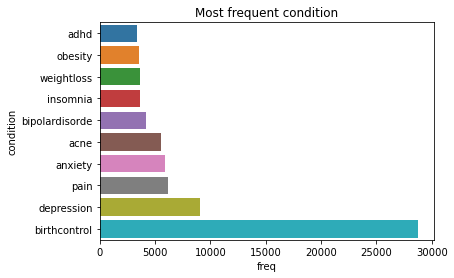

In [86]:
# Number of topics to use in the algorithm
NUMBER_OF_TOPICS = 5
condition_freq = drugs_train.groupby('condition').count().reset_index().drop(['review'], axis=1).rename(columns={'drugName':'freq'})
condition_freq_top10 = condition_freq.sort_values(by=['freq']).tail(10)
ax = sns.barplot(x="freq", y="condition", data=condition_freq_top10)
plt.title('Most frequent condition')
print('Percentage of data within th top 10', condition_freq_top10['freq'].sum()/condition_freq['freq'].sum())
# we will save the name of the top n conditions to use later on
top_conditions = list(condition_freq_top10.head(NUMBER_OF_TOPICS).condition)

Most frequent condition is birthcontrol, with a huge gap from the rest like depression, pain, etc.

Percentage of data within th top 10 0.20456055875308782


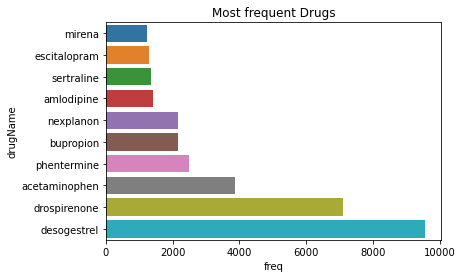

In [87]:
drug_freq = drugs_train.groupby('drugName').count().reset_index().drop(['review'], axis=1).rename(columns={'condition':'freq'})
drug_freq_top10 = drug_freq.sort_values(by=['freq']).tail(10)
ax = sns.barplot(x="freq", y="drugName", data=drug_freq_top10)
plt.title('Most frequent Drugs')
print('Percentage of data within th top 10', drug_freq_top10['freq'].sum()/drug_freq['freq'].sum())

Most frequent drug is desogestrel followed with drosipirenone, aceetaminophen, phentermine, etc.

As we have too many different labels, we are going to use the top N conditions with more frequency to avoid confusing the algorithm

In [88]:
drugs_train = drugs_train[drugs_train.condition.apply(lambda x: x in top_conditions)]
drugs_test = drugs_test[drugs_test.condition.apply(lambda x: x in top_conditions)]

Only thing we have left is to clean and tokenize the review feature

In [89]:
# Remove the '"' character
drugs_train.review = drugs_train.review.apply(lambda x: x.replace('"',''))
drugs_test.review = drugs_test.review.apply(lambda x: x.replace('"',''))
drugs_train.head()

,drugName,condition,review
1,guanfacine,adhd,My son is halfway through his fourth week of I...
7,aripiprazole,bipolardisorde,Abilify changed my life. There is hope. I was ...
15,liraglutide,obesity,I have been taking Saxenda since July 2016. I...
18,lamotrigine,bipolardisorde,I&#039;ve been on every medicine under the sun...
21,trazodone,insomnia,"I have insomnia, it&#039;s horrible. My story ..."


We've found some weird values in the reviews! we have found some html tags like '</span>' and some html escape codes like '&#039', so we are goint to crean this by deleting the tags and replacing the escapecodes with  the original character

In [90]:
import html
import re
def cleanHTML(x):
    tag_expr = '<(\/)?[a-zA-Z0-9_]+>'
    x.drugName = html.unescape(re.sub(tag_expr, '', x.drugName))
    x.condition = html.unescape(re.sub(tag_expr, '', x.condition))
    x.review = html.unescape(re.sub(tag_expr, '', x.review))
    return x

drugs_train = drugs_train.apply(cleanHTML, axis=1)
drugs_test = drugs_test.apply(cleanHTML, axis=1)

Now we're going to merge drugName and review columns to process them together.

In [91]:
drugs_train['review'] = drugs_train['drugName'] + ' ' + drugs_train['review']
drugs_test['review'] = drugs_test['drugName'] + ' ' + drugs_test['review']
drugs_train.drop(axis=1, columns=['drugName'], inplace=True)
drugs_test.drop(axis=1, columns=['drugName'], inplace=True)
drugs_train.head()

,condition,review
1,adhd,guanfacine My son is halfway through his fourt...
7,bipolardisorde,aripiprazole Abilify changed my life. There is...
15,obesity,liraglutide I have been taking Saxenda since J...
18,bipolardisorde,lamotrigine I've been on every medicine under ...
21,insomnia,"trazodone I have insomnia, it's horrible. My s..."


Now we're goung to use the top_conditions var to generate a dict which will pair them with their index and use it to generate the 'books' of each condition, these books are the concatenation of all the reviews related to that condition

In [96]:
condition_books_dict = {k: v for v, k in enumerate(top_conditions)}
condition_books_train = ['']*NUMBER_OF_TOPICS
condition_books_test = ['']*NUMBER_OF_TOPICS

In [110]:
def create_books(x, books):
    books[condition_books_dict[x.condition]] = books[condition_books_dict[x.condition]] + x.review
drugs_train.apply(lambda x: create_books(x, condition_books_train), axis=1)
drugs_test.apply(lambda x: create_books(x, condition_books_test), axis=1)

3        None
12       None
14       None
18       None
20       None
         ... 
53739    None
53744    None
53750    None
53754    None
53756    None
Length: 6174, dtype: object

In [111]:
condition_books_train[0]

'guanfacine My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective.daytrana Hi all, My son who is 12 was diagnosed when he was in 2nd grade. We tried everything before medication. When we tried meds, the first one made him loose weight, fast. The second gave him a nasty tic that thankfully went away as soon as he